<div style="color:#8b1538; font-size:35px;">Benchmark of stairway plot 2</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

In [44]:
multiplicator, diff, pos_l = set(), [], []
path_data = "../decline/"
for fichier in os.listdir(path_data):
    # Read file
    res = pd.read_json("{}{}".format(path_data, fichier))[['Variants']].iloc[0]['Variants'][0]
    
    # Get pos
    pos = [ele[0] for ele in res]
    
    # Get multiplicator
    number = 10
    test = np.unique(np.round(np.array(pos) * number)).size == len(pos)
    while test is False:
        number *= 10
        test = np.unique(np.round(np.array(pos) * number)).size == len(pos)
        if number == 1e4:
            break
    multiplicator.add(number)
    
    tmp = len(pos) - len(np.unique(np.round(np.array(pos) * number)))
    if tmp > 0:
        diff.append(tmp)
        pos_l.append(len(pos))
        #print("{:>40}: {} vs {}".format(fichier, len(pos), len(np.unique(np.round(np.array(pos) * number)))), end="\n\n")

<br>

> Read files in final folder

In [71]:
def read_stairway_final(path):
    data = {'M0': {'LL': [], 'Theta': []}, 'M1': {'LL': [], 'Theta': []}, 'Final': {'LL': [], 'Theta': []}}

    for fichier in os.listdir(path)[:3]:
        with open("{}{}".format(path, fichier), 'r') as filin:
            lines = filin.readlines()

            models = [line.strip().split('\t') for line in lines[:-2] if line.startswith('dim')]
            
            # M0: Log likelihood and theta for 1 dimensional model, i.e. the constant model
            _, _, _, ll, _, _, _, theta = models[0]
            data['M0']['LL'].append(-float(ll))
            data['M0']['Theta'].append(float(theta))
            
            # M1: Log likelihood and theta for 2 dimensionals model, i.e. the various population model
            if len(models) == 1:
                for value in data['M1'].values():
                    value.append(np.nan)
            else:
                _, _, _, ll, _, _, _, _, theta1, theta2 = models[1]
                theta = [float(theta1), float(theta2)]
                data['M1']['LL'].append(-float(ll))
                data['M1']['Theta'].append((min(theta), max(theta)))  # pair (Theta min, Theta max)

            # Final: Log likelihood and theta for the final model - x dimension
            _, ll, _ = lines[-3].strip().split('\t')  # line that startswith final
            data['Final']['LL'].append(-float(ll))
            
            line = [float(ele) for ele in lines[-1].strip().split(' ')]
            data['Final']['Theta'].append((min(line), max(line)))  # pair (Theta min, Theta max)
            
    return data

In [72]:
read_stairway_final(path="./sei/inference/stairway_plot_v2.1.1/stairway_decline-tau=-3.9_kappa=-0.1/stairway_inference/final/")

{'M0': {'LL': [-76.43578770774184, -68.65904245956335, -74.05015192535939],
  'Theta': [0.027928184678686643, 0.028302164505454655, 0.0285901699548827]},
 'M1': {'LL': [nan, nan, -75.18165902147302],
  'Theta': [nan, nan, (0.02775470701666972, 0.030098906737809034)]},
 'Final': {'LL': [-76.36060172267025, -68.86143577552866, -75.76965114660561],
  'Theta': [(2696.6723934006304, 3050.4636332748396),
   (2703.5780173950225, 2889.7598203562006),
   (2532.394844560211, 3016.4054640485365)]}}

> Read stairway summary

In [91]:
def min_max(data):
    """
    Compute the min & max (value and index) of a list

    Return
    ------
    Pair Ne min (value, [index]) & Ne max (value, [index])
    """
    minimum, maximum = min(data), max(data)
    index_min = [i for i, ele in enumerate(data) if ele == minimum]
    index_max = [i for i, ele in enumerate(data) if ele == maximum]
    return (minimum, index_min), (maximum, index_max)


def read_stairway_summary(fichier):

    with open(fichier, "r") as filin:
        lines = filin.readlines()
        ne_list, year_list = [], []
        
        for line in lines[1:]:
            _, _, _, _, _, year, ne, _, _, _, _ = line.strip().split('\t')
            ne_list.append(float(ne))
            year_list.append(float(year))

        # Pair Ne min (value, [index]) & Ne max (value, [index])
        minimum, maximum = min_max(ne_list)

    data = {
        'Ne': (minimum[0], maximum[0]), 
        'Year': (np.mean([year_list[i] for i in minimum[1]]), np.mean([year_list[i] for i in maximum[1]])),
        'Ne initial': ne_list[0],
        'Ne ancestral': ne_list[-1],
        'Ne mean': np.mean(ne_list)
    }

    return data

In [92]:
read_stairway_summary(fichier="./sei/inference/stairway_plot_v2.1.1/stairway_decline-tau=-4.0_kappa=-3.5/stairway_inference/stairway_inference.final.summary")

{'Ne': (0.050740010530045884, 0.625),
 'Year': (0.04234136105422526, 0.004941333248485727),
 'Ne initial': 0.625,
 'Ne ancestral': 0.06228079246912518}

# Stairway plot 2 inference

<div style="color: #8b1538; font-size: 32px">1. Log-likelihood ratio test</div><br>

Likelihood ratio test lrt assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

1. Likelihood ratio test

\begin{equation}
\large{ lrt = -2*\frac{L0}{L1} }
\end{equation}

with L0 the likelihood of m0 and L1 the likelihood of m1 <br>

2. Log-likelihood ratio test

\begin{equation}
\large{ log(lrt) = 2 * (log_{10}L1 - log_{10}L0) }
\end{equation}

with $log_{10}L0$ the log-likelihood of m0 and $log_{10}L1$ the log-likelihood of m1

<br>

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

> Load Data for stairway inference

In [3]:
data = f.export_stairway_files(model='decline', fold=False)

In [4]:
data

,M0,M1,Ne,Year,Parameters,Final,Ne ancestral,Ne initial,Ne mean
0,"{'LL': [-933.8893835973, -891.2878404772, -958...","{'LL': [-297.651768771, -105.5928209359, -98.2...","[0.0733375977, 0.4552526361]","[0.022095391500000002, 0.0041079475]","{'Tau': 0.0039810717, 'Kappa': 0.0316227766}","{'LL': [-105.2000777619, -96.1658141268, -88.7...",0.075228,0.455253,0.126783
1,"{'LL': [-89.1049159667, -88.2256489708, -88.00...","{'LL': [None, None, None, None, None, None, No...","[0.0875817896, 0.0882927792]","[0.0005208783, 0.1588551352]","{'Tau': 199.5262314969, 'Kappa': 0.0050118723}","{'LL': [-89.1247200039, -88.1519614966, -88.52...",0.088276,0.087582,0.087980
2,"{'LL': [-91.2214332288, -94.0129340896, -91.36...","{'LL': [None, None, None, None, None, None, No...","[0.0877598245, 0.0882258857]","[0.0005026299, 0.0999382291]","{'Tau': 63.095734448, 'Kappa': 50.1187233627}","{'LL': [-92.1089174906, -94.5102765202, -91.66...",0.088168,0.087760,0.088038
3,"{'LL': [-94.1735171732, -90.1006447212, -87.35...","{'LL': [None, None, None, None, None, None, No...","[0.08798466270000001, 0.08854751350000001]","[0.0344383682, 0.0009266111000000001]","{'Tau': 0.00019952620000000001, 'Kappa': 5.011...","{'LL': [-94.3531722045, -90.0610891595, -87.64...",0.087997,0.088548,0.088133
4,"{'LL': [-1528.4542822805, -1477.7232852583, -1...","{'LL': [-121.1479644137, -158.5973518011, -97....","[0.06977382530000001, 0.5457110128]","[0.025391838700000002, 0.0043005261]","{'Tau': 0.015848931900000002, 'Kappa': 0.07943...","{'LL': [-90.9642085284, -90.143814838, -94.960...",0.070447,0.545711,0.138941
...,...,...,...,...,...,...,...,...,...
4220,"{'LL': [-99.7285371735, -99.499769161, -94.486...","{'LL': [-93.4905081405, -92.2980155069, -90.13...","[0.0647324316, 0.0894184794]","[0.0001158865, 0.0086061922]","{'Tau': 0.0079432823, 'Kappa': 19.9526231497}","{'LL': [-93.1471478338, -92.3144533867, -90.13...",0.089135,0.064732,0.087041
4221,"{'LL': [-389.3266748292, -366.6488763969, -359...","{'LL': [-90.5053058439, -91.3111284766, -133.8...","[0.0089908364, 0.09712984270000001]","[9.136300000000001e-06, 0.0160935583]","{'Tau': 0.0794328235, 'Kappa': 31.6227766017}","{'LL': [-90.2595337126, -89.3915651701, -93.25...",0.096961,0.008991,0.074211
4222,"{'LL': [-94.5246048141, -112.1900332374, -103....","{'LL': [-89.4446128565, -98.3500543586, -92.15...","[0.0855879066, 0.0923795243]","[0.0352824286, 0.1588563658]","{'Tau': 12.5892541179, 'Kappa': 19.9526231497}","{'LL': [-88.7267691721, -98.1939947782, -92.09...",0.092380,0.085944,0.086913
4223,"{'LL': [-1296.936066004, -1193.1560139111, -12...","{'LL': [-125.4943002183, -107.8779312368, -116...","[0.000695486, 0.1140745335]","[1.0916e-06, 0.030025576800000002]","{'Tau': 0.1995262315, 'Kappa': 316.2277660168}","{'LL': [-99.3504318544, -93.5175770284, -105.3...",0.108861,0.000695,0.057485


In [27]:
data.iloc[0]['Final']['Theta'][:10]

[[7441.6932215712, 208904.4477387863],
 [20992.0061660719, 111222.3108246309],
 [5293.6091950462, 115332.1606347026],
 [3132.7585049933, 87943.2576846071],
 [24222.4743732042, 132390.7045281956],
 [6636.3039813186, 174251.4509546066],
 [5015.9359898881, 112363.5311975009],
 [22961.8494903566, 174888.8632435483],
 [17303.3381064328, 216194.82],
 [10634.0306458543, 109635.3043971216]]

> Log-likelihood ratio test

In [14]:
def stairway_ll_test(data):
    key = [param for param in data.iloc[0]['Parameters'].keys()]
    df = pd.DataFrame(columns=[key[0], key[1], 'Positive hit'])

    # Pre-processing data
    for _, row in data.iterrows():
        # Extract parameters use to generate the observed SFS
        # Then compute log10 of these parameters
        dico = {}
        for param in row['Parameters'].keys():
            dico[param] = round(np.log10(row['Parameters'][param]), 2)
        
        # Compute log-likelihood ratio test
        dico['Positive hit'] = sum([sei.likelihood_ratio_test(ll_m0, ll_m1, dof=2) if ll_m1 is not None else 0 for ll_m0, ll_m1 in zip(row['M0']['LL'], row['M1']['LL'])])
        
        # Add to pandas DataFrame df
        df = df.append(dico, ignore_index=True)
        
    return df
    
ll_data = stairway_ll_test(data)

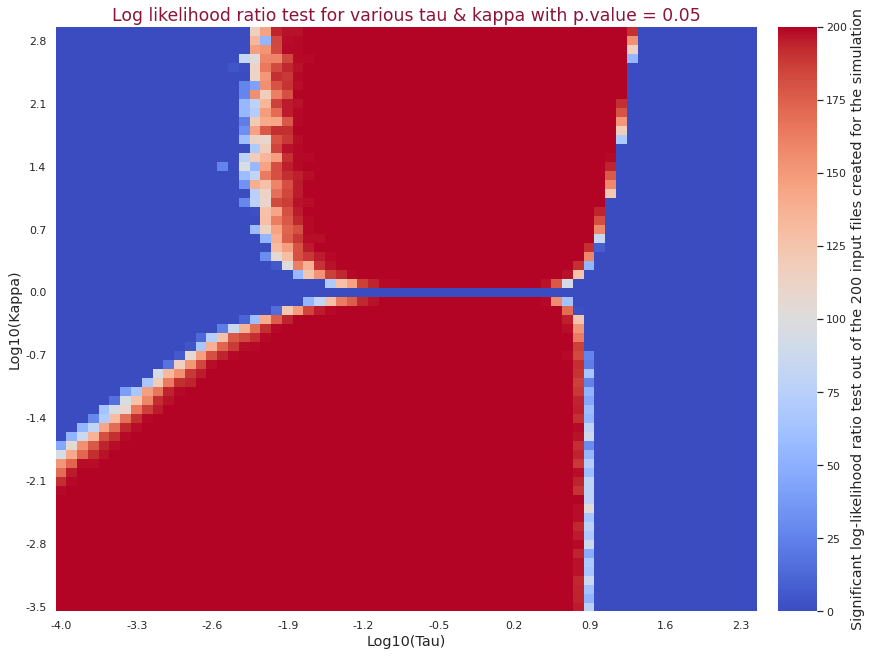

In [15]:
def plot_likelihood_stairway(data):
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Pre-processing data
    df = data.pivot(index=data.columns[1], columns=data.columns[0], values='Positive hit')

    # Plot
    ax = sns.heatmap(df, cmap='coolwarm')

    # Heatmap x and y-axis personnalization
    plot.heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, 
                      cbar='Significant log-likelihood ratio test out of the 200 input files created for the simulation')

    # Title
    title = "Log likelihood ratio test for various tau & kappa with p.value = 0.05"
    plt.title(title, fontsize="x-large", color="#8b1538")

    plt.plot()


plot_likelihood_stairway(ll_data)

> Detection changement de taille de population

Changement de taille significatif

In [24]:
def stairway_ne(data):
    key = [param for param in data.iloc[0]['Parameters'].keys()]
    df = pd.DataFrame(columns=[key[0], key[1], 'Ne'])

    # Pre-processing data
    for _, row in data.iterrows():
        # Extract parameters use to generate the observed SFS
        # Then compute log10 of these parameters
        dico = {}
        for param in row['Parameters'].keys():
            dico[param] = round(np.log10(row['Parameters'][param]), 2)
        
        # Compute distance - (max - min)**2 / max
        dico['Ne'] = np.log10(np.power(row['Ne'][1] - row['Ne'][0], 2) / row['Ne'][1])
        
        # Add to pandas DataFrame df
        df = df.append(dico, ignore_index=True)
        
    return df
    
ne_data = stairway_ne(data)

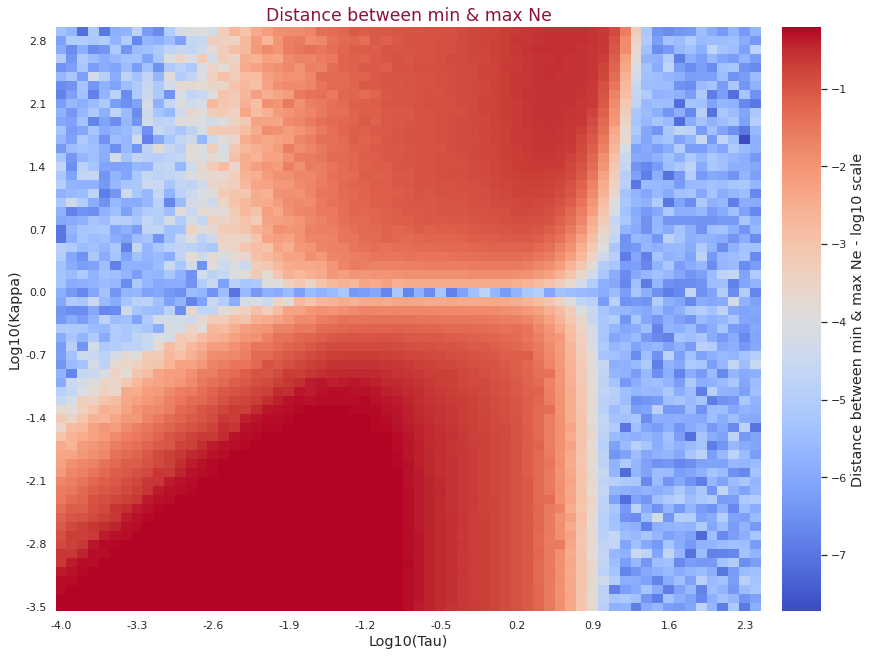

In [39]:
def plot_ne_stairway(data):
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Pre-processing data
    df = data.pivot(index=data.columns[1], columns=data.columns[0], values='Ne')

    # Plot
    ax = sns.heatmap(df, cmap='coolwarm')

    # Heatmap x and y-axis personnalization
    plot.heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, 
                      cbar='Distance between min & max Ne - log10 scale')

    # Title
    title = "Distance between min & max Ne"
    plt.title(title, fontsize="x-large", color="#8b1538")

    plt.plot()


plot_ne_stairway(ne_data)

> Estimation parameters

In [8]:
def stairway_param(data, param):
    key = [param for param in data.iloc[0]['Parameters'].keys()]
    df = pd.DataFrame(columns=[key[0], key[1], 'Distance'])

    tmp = 'Year' if param == 'Tau'  else 'Ne'
    
    # Pre-processing data
    for _, row in data.iterrows():
        # Extract parameters use to generate the observed SFS
        # Then compute log10 of these parameters
        dico = {}
        for param in row['Parameters'].keys():
            dico[param] = round(np.log10(row['Parameters'][param]), 2)
        
        # Compute distance - (estimated - observed)**2 / estimated
        #estimated = abs(row[tmp][0] - row[tmp][1])
        estimated = np.mean([row[tmp][0], row[tmp][1]])
        #dico['Distance'] = np.log10(np.power(estimated - row['Parameters'][param], 2) / row['Parameters'][param])
        df['Estimated'] = estimated
        
        # Add to pandas DataFrame df
        df = df.append(dico, ignore_index=True)
        
    return df


def plot_param_stairway(data, param):
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Pre-processing data
    data = stairway_param(data, param)
    df = data.pivot(index=data.columns[1], columns=data.columns[0], values='Estimated')

    # Plot
    ax = sns.heatmap(df, cmap='coolwarm')

    # Heatmap x and y-axis personnalization
    plot.heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, 
                      cbar='Distance - log10 scale')

    # Title
    title = "Distance between observed and inferred {}".format(param)
    plt.title(title, fontsize="x-large", color="#8b1538")

    plt.plot()

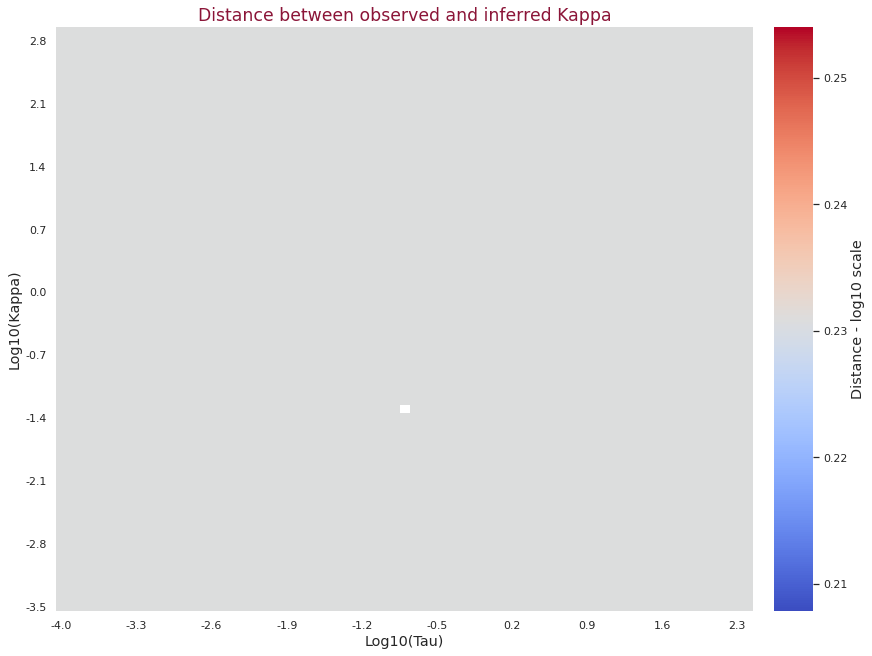

In [15]:
plot_param_stairway(data, param='Kappa')

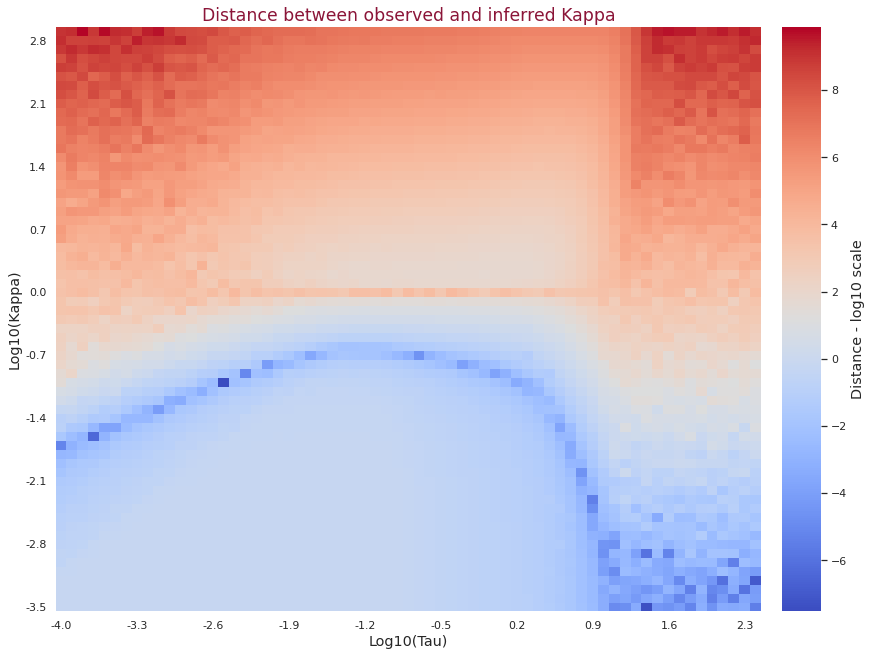

In [51]:
plot_param_stairway(data, param='Kappa')

In [14]:
data

,M0,M1,Ne,Year,Parameters
0,"{'LL': [-967.4845888568, -1030.3196428092, -94...","{'LL': [-100.8186991792, -97.1191464411, -92.2...","[0.0702143523, 0.38541658100000004]","[0.0250339569, 0.0039738638000000005]","{'Tau': 0.0039810717, 'Kappa': 0.0316227766}"
1,"{'LL': [-88.2679775655, -90.1124777482, -94.10...","{'LL': [-88.334204453, -90.0306831719, -95.383...","[0.0875148188, 0.0882960612]","[0.0004438639, 0.1586775387]","{'Tau': 199.5262314969, 'Kappa': 0.0050118723}"
2,"{'LL': [-95.9554206082, -90.1738181002, -94.65...","{'LL': [-98.2505174368, -91.2325766655, -94.97...","[0.0877473373, 0.0881673573]","[0.0005188672000000001, 0.15863038570000002]","{'Tau': 63.095734448, 'Kappa': 50.1187233627}"
3,"{'LL': [-88.9408499678, -89.0439688754, -92.34...","{'LL': [-89.467665772, -89.3503474356, -93.032...","[0.0879613388, 0.0887128674]","[0.2461090958, 0.0009292249000000001]","{'Tau': 0.00019952620000000001, 'Kappa': 5.011..."
4,"{'LL': [-1495.7918991642, -1554.2948288745, -1...","{'LL': [-89.5613130359, -93.1438976275, -89.07...","[0.07035505140000001, 0.591852959]","[0.0234586988, 0.005598833]","{'Tau': 0.015848931900000002, 'Kappa': 0.07943..."
...,...,...,...,...,...
4220,"{'LL': [-102.3148282021, -93.9360029283, -97.4...","{'LL': [-93.1966760037, -93.9439216508, -96.32...","[0.0637807524, 0.0894906977]","[0.00011693040000000001, 0.0087040564]","{'Tau': 0.0079432823, 'Kappa': 19.9526231497}"
4221,"{'LL': [-379.2427814347, -363.3807859551, -360...","{'LL': [-92.6740940874, -94.7001965968, -88.60...","[0.0087938553, 0.0971964515]","[1.69001e-05, 0.014673588000000001]","{'Tau': 0.0794328235, 'Kappa': 31.6227766017}"
4222,"{'LL': [-103.4596727439, -94.8017546996, -102....","{'LL': [-95.3868735279, -95.1218885095, -95.92...","[0.08556333690000001, 0.0924370311]","[0.0594438953, 0.1584312605]","{'Tau': 12.5892541179, 'Kappa': 19.9526231497}"
4223,"{'LL': [-1299.7090701577, -1204.7574874163, -1...","{'LL': [-94.6105828835, -93.5797238755, -95.85...","[0.0009353277, 0.1184658298]","[5.5653e-06, 0.0122089378]","{'Tau': 0.1995262315, 'Kappa': 316.2277660168}"


<br>

### Constan population

Stairway plot inference for some constant population with Ne = 1, Ne = 2, Ne = 10 & Ne = 100.

In [2]:
def sfs_cst_pop():
    # DataFrame
    data = pd.DataFrame(columns=['Parameters', 'SNPs', 'SFS observed'])
    
    # Parameters for the simulation
    params = {"sample_size": 20, "Ne": 0, "rcb_rate": 2e-2, "mu": 2e-2, "length": 1e5}
    
    for ne in [1, 2, 10]:
        params['Ne'] = ne
        
        # Constant scenario
        sfs = ms.msprime_simulation(model=ms.constant_model, params=params, debug=True)
        
        dico = {'Parameters': params.copy(), 'SNPs': [np.mean(sfs)], 'SFS observed': [sfs]}
        data = data.append(dico, ignore_index=True)
        
    return data


def inference_cst_pop(generate=False):
    if generate:
        data = sfs_cst_pop()
        data.to_json("./Data/Msprime/cst/SFS-cst")
    else:
        data = pd.read_json("./Data/Msprime/cst/SFS-cst")
        
    return data

In [3]:
simulation = inference_cst_pop(generate=False)

In [4]:
simulation

,Parameters,SNPs,SFS observed
0,"{'sample_size': 20, 'Ne': 1, 'rcb_rate': 0.02,...",[1462.1578947368],"[[7471, 4056, 2625, 1957, 1514, 1294, 1165, 10..."
1,"{'sample_size': 20, 'Ne': 2, 'rcb_rate': 0.02,...",[2986.1052631579],"[[15996, 8189, 5265, 4084, 3094, 2723, 2093, 2..."
2,"{'sample_size': 20, 'Ne': 10, 'rcb_rate': 0.02...",[15017.8421052632],"[[80377, 40178, 26825, 20229, 16309, 13161, 11..."


In [5]:
%%capture

for _, row in simulation.iterrows():
    sei.save_stairway_inference(row, 'cst')
    break

<br>

In [6]:
data = pd.read_json("./Data/Msprime/decline/SFS_decline-all")

Text(0.5, 1.0, "{'Tau': 0.0006309573, 'Kappa': 794.3282347243}")

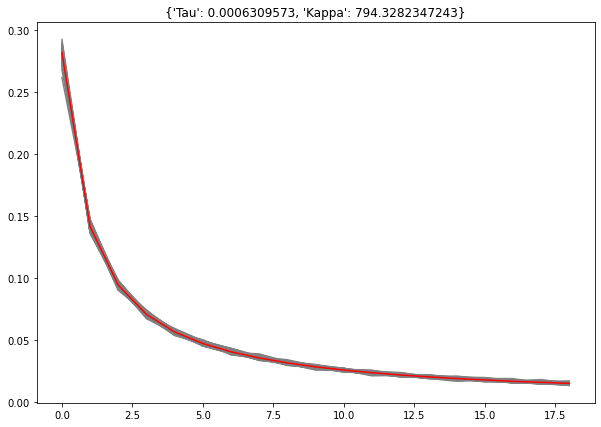

In [75]:
sfs = data.iloc[0]['SFS observed']
new = np.array([sum(spectrum) for spectrum in zip(*sfs)]) / len(sfs)

plt.figure(figsize=(10, 7))

for spectrum in sfs:
    plt.plot([ele/sum(spectrum) for ele in spectrum], color="grey")
plt.plot([ele/sum(new) for ele in new], color="red")
plt.title({k: v for k, v in data.iloc[0]['Parameters'].items() if k in ['Tau', 'Kappa']})